In [1]:
import torch
torch.autograd.functional.jacobian

import matplotlib.pyplot as plt
from utils import camera_intr, ellipse_ndim

In [2]:
intr = camera_intr(f_x=1, f_y=1, x_0=.5, y_0=.5, s=0)

In [3]:
mu = torch.tensor([
    [0.3, 0.3, 2.],
    [0., 0., 3.],
])
cov = torch.tensor([
    [[1., .9, 0.],
     [.9, 1.,  0.],
     [0., 0., 3.]],
    [[1., -.9, 0.],
     [-.9, 1., 0.],
     [0., 0., 3.]],
])
col = torch.tensor([
    [0, 0, 1],
    [0, 0, 1]
])

In [4]:
def J(mu, K):
    N = len(mu)
    x, y, z = mu[:,0], mu[:,1], mu[:,2]
    f_x, f_y = K[0,0], K[1,1]

    J = torch.zeros((N, 2, 3))
    J[:,0,0] = f_x/z
    J[:,1,1] = f_y/z

    J[:,0,2] = -(f_x*x/z**2)
    J[:,1,2] = -(f_y*y/z**2)

    return J

In [5]:
mu_ = (intr @ mu.T)
mu_ = (mu_[:2] / mu_[2]).T
cov_ = J(mu, intr) @ cov @ J(mu, intr).permute(0,2,1)

tensor([0.6500, 0.6500]) tensor([[0.2669, 0.2419],
        [0.2419, 0.2669]])
tensor([0.5000, 0.5000]) tensor([[ 0.1111, -0.1000],
        [-0.1000,  0.1111]])


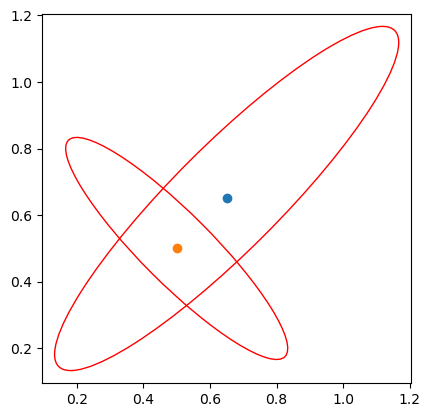

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ellipse_ndim(mu_, cov_, ax, edgecolor='red')
ax.scatter(mu_[0,0], mu_[0,1])
ax.scatter(mu_[1,0], mu_[1,1])
ax.set_aspect('equal', adjustable='box')

## Render Color

$$ g(\boldsymbol{x}) = exp\left( - \frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T \Sigma^{-1}(\boldsymbol{x} - \boldsymbol{\mu})\right) $$

In [7]:
def g(x, m, S):
    ''' x: (h*w, 2) matrix
        m: (2, 1) mean
        S: (2, 2) cov matrix
    '''
    
    x = x.T.view(-1, 1, 2)
    m = m.view(1, 1, 2)

    S_inv = torch.linalg.inv(S)
    x_m = x - m

    return torch.exp(-(1/2)*x_m @ S_inv @ x_m.permute(0,2,1))

In [8]:
x, y = torch.meshgrid(torch.linspace(0,1,100),torch.linspace(0,1,100), indexing='xy')

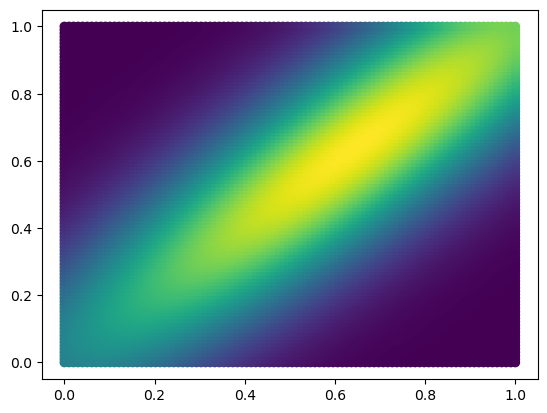

In [9]:
plt.scatter(x.flatten(), y.flatten(), c=g(torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0), mu_[0], cov_[0]))

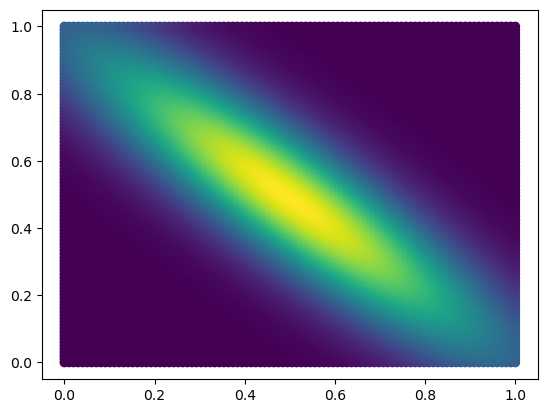

In [10]:
plt.scatter(x.flatten(), y.flatten(), c=g(torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0), mu_[1], cov_[1]))

In [11]:
g(torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0), mu_[0], cov_[0]).view(100,100).shape

torch.Size([100, 100])

In [12]:
col[0]

tensor([0, 0, 1])

In [13]:
(g(torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0), mu_[0], cov_[0]).view(1,100,100) * col[0].view(3,1,1)).shape

torch.Size([3, 100, 100])

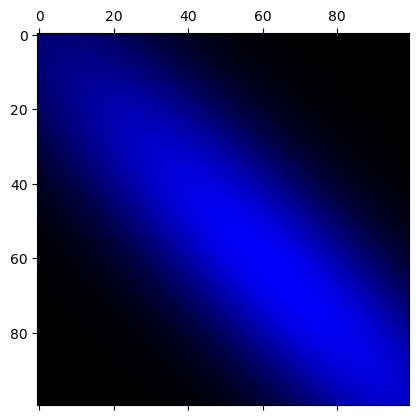

In [14]:
plt.matshow((g(torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0), mu_[0], cov_[0]).view(1,100,100) * col[0].view(3,1,1)).permute((1,2,0)))

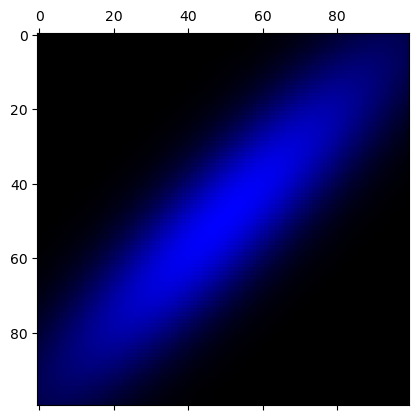

In [15]:
plt.matshow((g(torch.cat((x.reshape(1,-1),y.reshape(1,-1)), dim=0), mu_[1], cov_[1]).view(1,100,100) * col[1].view(3,1,1)).permute((1,2,0)))